# Differences among biomes

We want to determine if the differnces between iNaturalist observations and sPlotOpen cwm's differ across different biomes.

This section covers:

- Load WWF terrestrial ecoregions and biomes
- Clip observations into biomes
- Calculate grid means for each biome
- Visualize differences in boxplot
- Quantification Average Difference

In [ ]:
# packages
import os
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import geopandas as gpd
from geopandas.tools import sjoin

## Load WWF biome data

We use the terrestrial biomes, as defined in the WWF terrestrial ecoregion map. The WWF terrestrial ecoregions shape files were downloaded from www.worldwildlife.org/publications/terrestrial-ecoregions-of-the-world.

In [3]:
wwf = gpd.read_file("WWF/wwf_terr_ecos.shp")
# remove arctic and antarctica
wwf = wwf[wwf["BIOME"] < 98]

In [4]:
wwf.head()

,OBJECTID,AREA,PERIMETER,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,...,G200_BIOME,G200_STAT,Shape_Leng,Shape_Area,area_km2,eco_code,PER_area,PER_area_1,PER_area_2,geometry
0,1,29.802942,0.219,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,0.219475,0.002769,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-112.26972 29.32648, -112.28809 29.3..."
1,2,11.977824,0.193,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,0.193289,0.001111,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-112.19907 29.17528, -112.20740 29.1..."
2,3,77301.372760,111.954,Sinaloan dry forests,NT,2.0,28.0,60228.0,98.0,1.0,...,2.0,1.0,111.951414,6.879188,77362,NT0228,0.0,0.0,0.0,"POLYGON ((-109.11700 27.74142, -109.11228 27.7..."
3,4,215.489182,1.274,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,1.273654,0.019701,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-110.54179 27.38383, -110.54462 27.3..."
4,5,19.639089,0.363,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,0.363068,0.001791,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-110.52850 27.28641, -110.53336 27.2..."


### Visualize biomes

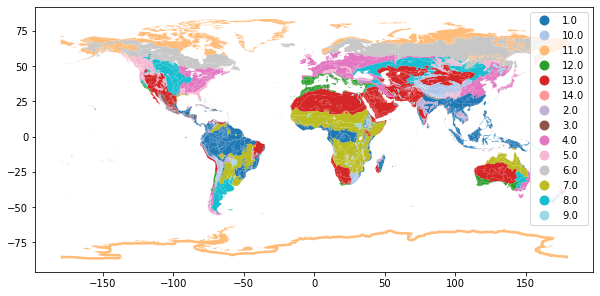

In [5]:
wwf['BIOME_str'] = wwf['BIOME'].astype(str)

fig, ax = plt.subplots(figsize = (10,15))
wwf.plot(column='BIOME_str', ax=ax, cmap="tab20", legend=True);

## Clip observations into biomes

### Load iNaturalist and sPlotOpen observations

In [6]:
iNat_TRY = pd.read_csv("iNat_TRY_log.csv")


In [ ]:
sPlot = pd.read_csv("sPlotOpen/cwm_loc.csv")

In [8]:
# make geopandas dataframes
# projection of wwf also in epsg:4326 
geo_iNat = gpd.GeoDataFrame( iNat_TRY.iloc[:,:24], geometry=gpd.points_from_xy(iNat_TRY.decimalLongitude, iNat_TRY.decimalLatitude), 
                            crs='epsg:4326')

In [9]:
geo_sPlot = gpd.GeoDataFrame(sPlot, geometry=gpd.points_from_xy(sPlot.Longitude, sPlot.Latitude), crs='epsg:4326')

### Clip observations

We use the geopandas ```clip()``` function to select the observations within the geometry of each biome:

In [10]:
# groupby wwf biomes
biomes = wwf.dissolve(by='BIOME')
biomes['BIOME'] = biomes.index

In [ ]:
# clip data into biomes 
# run-time about 45 min.

iNat_with_biome = pd.DataFrame(columns=geo_iNat.columns)
iNat_with_biome['BIOME']  = []

for index, row in biomes.iterrows():
    polygon = row['geometry'] #shape of biome
    clipped = geo_iNat.clip(polygon) #select all observations within this shape
    # add biome
    clipped['BIOME'] = row['BIOME'] #add biome to corresponding observations
    iNat_with_biome = pd.concat([iNat_with_biome, clipped]) 



In [12]:
sPlot_with_biome = pd.DataFrame(columns=geo_sPlot.columns)
sPlot_with_biome['BIOME']  = []

for index, row in biomes.iterrows():
    polygon = row['geometry']
    sPlot_clipped = geo_sPlot.clip(polygon)
    # add biome
    sPlot_clipped['BIOME'] = row['BIOME']
    sPlot_with_biome = pd.concat([sPlot_with_biome, sPlot_clipped])


In [13]:
sPlot_with_biome.drop('geometry',axis=1).to_csv(r'sPlot_biomes.csv', index=False) 

In [14]:
iNat_with_biome.drop('geometry',axis=1).to_csv(r'iNat_biomes.csv', index=False) 

## Calculate grid means for each biome

In [15]:
iNat_with_biome = pd.read_csv("iNat_biomes.csv")

In [16]:
sPlot_with_biome = pd.read_csv("sPlot_biomes.csv")

/net/home/swolf/.conda/envs/cartopy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
wwf = gpd.read_file("WWF/wwf_terr_ecos.shp")
# remove arctic and antarctica
wwf = wwf[wwf["BIOME"] < 98]

In [18]:
iNat_with_biome.head()

,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified,Dispersal unit length,Leaf Area,SLA,Leaf C,...,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length,BIOME
0,1990599612,Macaranga tanarius,23.122994,120.534961,2019-01-25T14:51:00,2019-01-27T13:49:07,NaN,10.997687,2.848944,NaN,...,NaN,1.064711,2.183426,3.427650,NaN,NaN,NaN,-0.785087,NaN,1.0
1,1990599668,Adiantum capillus-veneris,23.123053,120.536422,2019-01-25T15:36:00,2019-01-27T14:22:54,NaN,4.088585,4.030621,NaN,...,NaN,-1.021651,-1.213114,-1.890699,NaN,NaN,NaN,NaN,NaN,1.0
2,1978441599,Chloris barbata,23.123362,120.183891,2018-12-16T17:21:58,2018-12-16T13:14:40,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.565953,NaN,NaN,NaN,NaN,NaN,1.0
3,1883470731,Adiantum capillus-veneris,23.123363,120.536638,2018-03-11T11:48:00,2018-07-07T12:43:18,NaN,4.088585,4.030621,NaN,...,NaN,-1.021651,-1.213114,-1.890699,NaN,NaN,NaN,NaN,NaN,1.0
4,2242806671,Dioscorea bulbifera,23.123399,120.533835,2019-04-28T10:44:00,2019-05-03T12:45:18,NaN,5.093750,3.785888,NaN,...,NaN,NaN,NaN,1.736951,NaN,NaN,NaN,NaN,NaN,1.0


In [19]:
biome_types = sPlot_with_biome['BIOME'].unique().tolist() 

In [20]:
def global_grid_data(df, long, lat, deg, variables):
    
    # create new dataframe to save the average value of each grid cell and variable
    grouped_df = pd.DataFrame()
    
    # convert degree into step size
    step = int((360/deg) + 1)
    
    bins_x = np.linspace(-180,180,step) 
    bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))
    
    # group latitude and longitude coordinates into bins
    # create new columns 'x_bin' and 'y_bin'
    df['x_bin'] = pd.cut(df[long], bins=bins_x)
    df['y_bin'] = pd.cut(df[lat], bins=bins_y)
    
    # raster coordinates are in center of raster cell
    df['x_bin'] = df['x_bin'].apply(lambda x: ((x.left + x.right) /2) )
    df['y_bin'] = df['y_bin'].apply(lambda x: ((x.left + x.right) /2) )
    
    grouped_df = df.drop_duplicates(subset=['x_bin', 'y_bin'], keep='last')
    grouped_df = grouped_df[['x_bin', 'y_bin']]
    
    for v in variables:
        
        sub_df = df[['y_bin', 'x_bin', v]]
        grouped_v = sub_df.groupby(['x_bin', 'y_bin'], as_index=False)[v].mean()
        
        
        grouped_df = pd.merge(grouped_df, grouped_v, 
                    on= ['x_bin', 'y_bin'], 
                    how='left')
        
    return grouped_df

In [ ]:
trait = iNat_TRY.columns[6:24]


for i in biome_types:
    
    # subset biome
    iNat_sub = iNat_with_biome[iNat_with_biome['BIOME']==i]
    sPlot_sub = sPlot_with_biome[sPlot_with_biome['BIOME']==i]
    
    # get grid means
    df_iNat = global_grid_data(iNat_sub, 'decimalLongitude', 'decimalLatitude', deg=2, variables=trait)
    df_sPlot = global_grid_data(sPlot_sub, 'Longitude', 'Latitude', deg=2, variables=trait)
    
    # reshape data, so that we have only one Trait column
    df_iNat_t = df_iNat.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="TraitValue_iNat", 
                     var_name="Trait")
    
    df_sPlot_t = df_sPlot.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="TraitValue_sPlot", 
                     var_name="Trait")
    
    # merge sPlot and iNat data into one dataframe
    df_merged = pd.merge(df_sPlot_t, df_iNat_t, on=["x_bin", "y_bin", "Trait"] )
    
    # keep only lines where we have a pixel in both datasets
    df_merged = df_merged.dropna()
    
    # save result to csv
    filename="WWF/grid_means_biome" + str(i) + "_2deg.csv"
    df_merged.to_csv(filename, index=False)

Check work by plotting the different biomes:

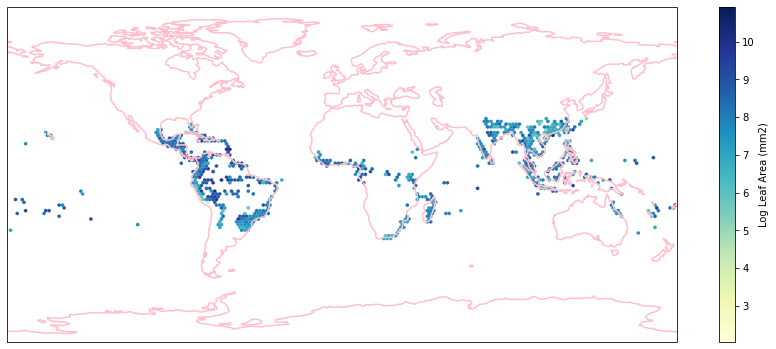

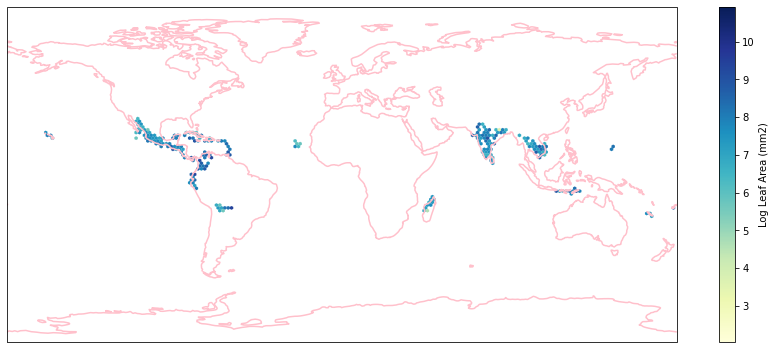

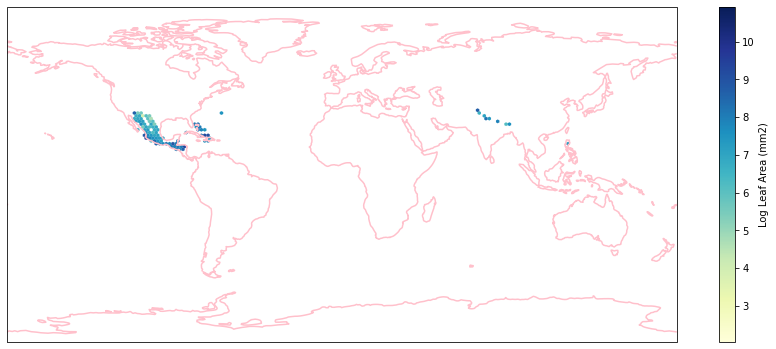

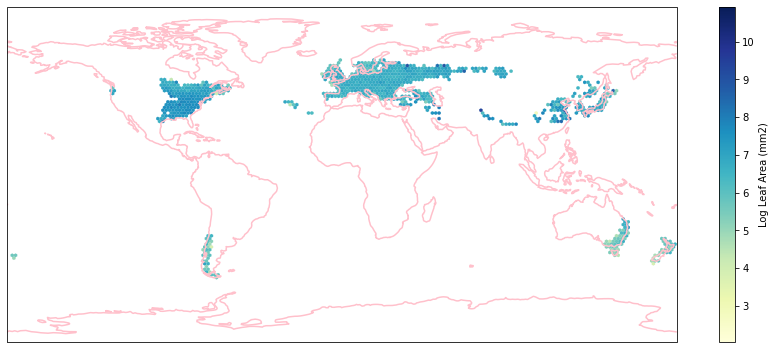

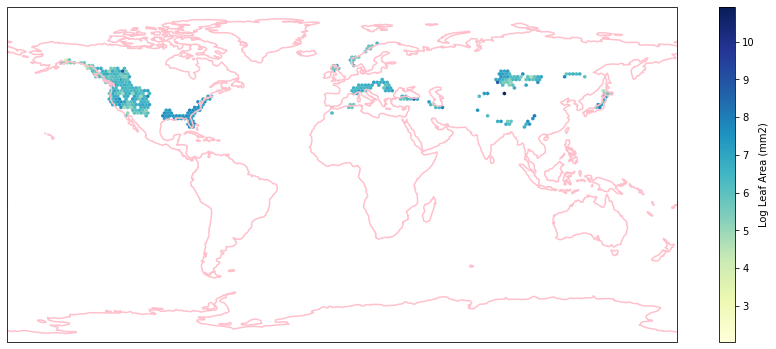

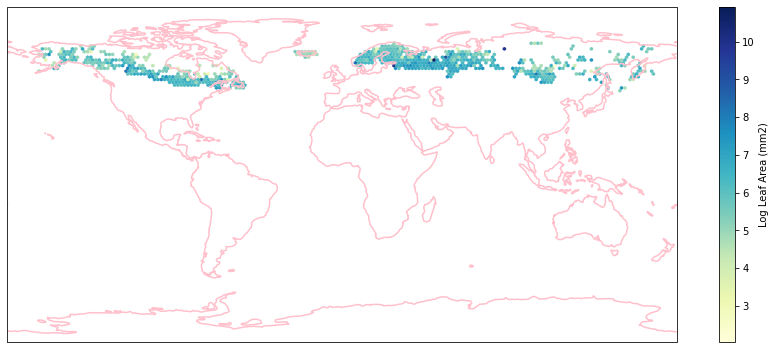

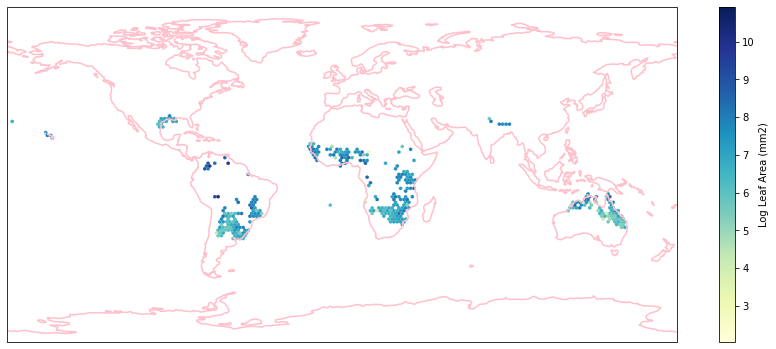

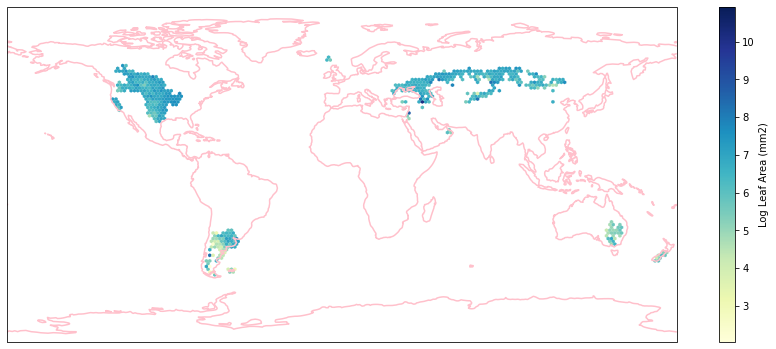

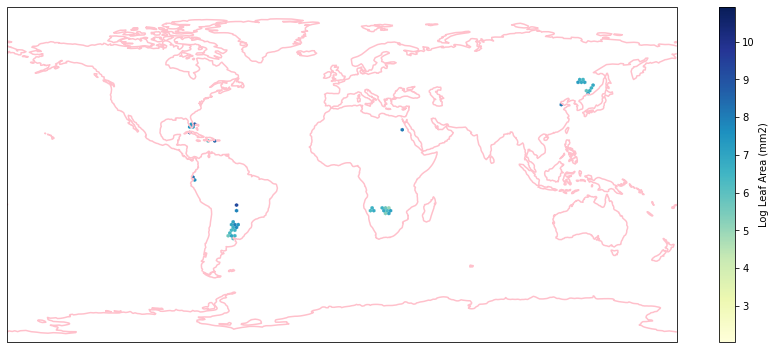

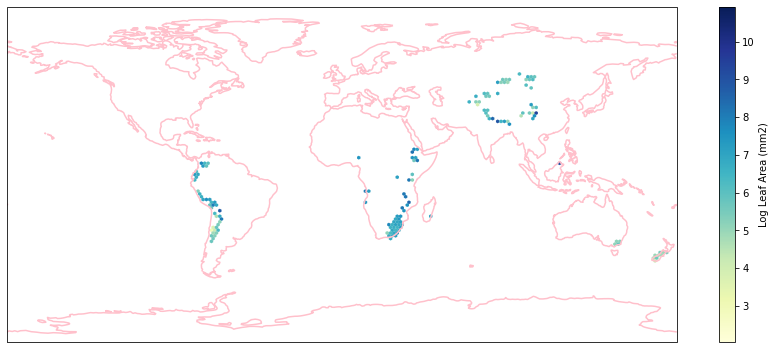

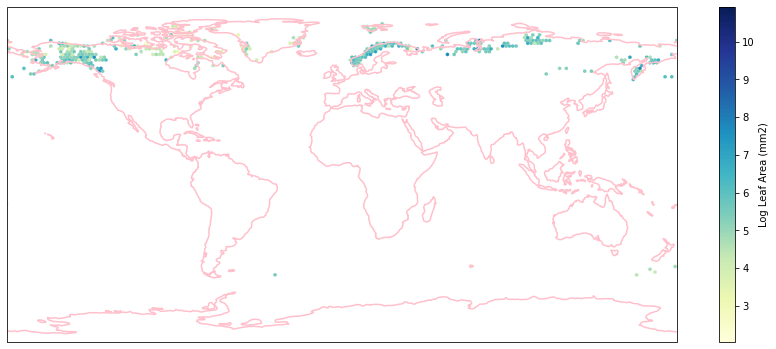

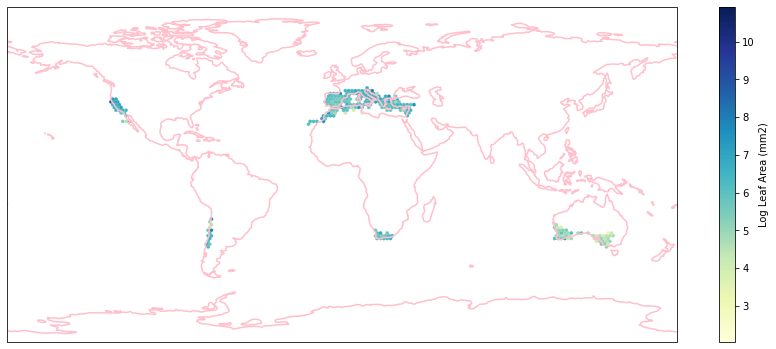

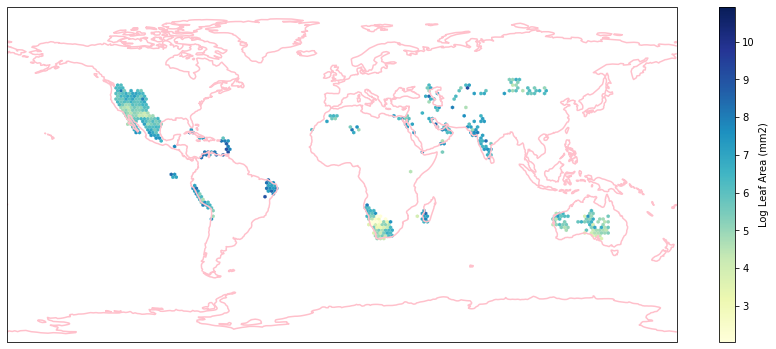

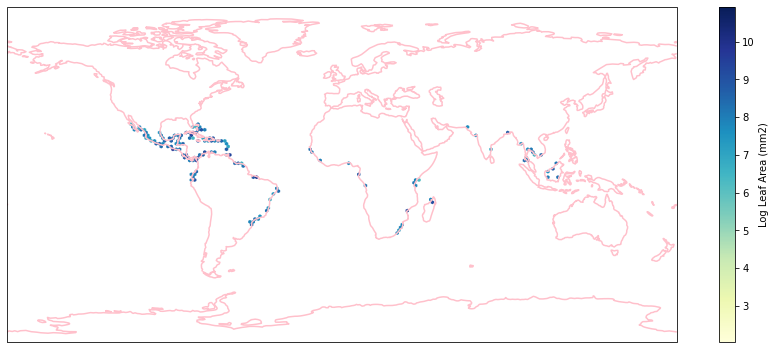

In [22]:
for i in biome_types:

    # cut iNaturalist into a grid based on latitude and longitude
    iNat_with_biome_sub = iNat_with_biome[iNat_with_biome['BIOME']==i]
    
    fig = plt.figure(figsize=(15, 15))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='pink', linewidth=1.5)
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    hb = ax.hexbin(iNat_with_biome_sub['decimalLongitude'], 
               iNat_with_biome_sub['decimalLatitude'], 
               C=iNat_with_biome_sub['Leaf Area'],
               reduce_C_function=np.mean,
               mincnt=1, 
               gridsize=(200, 60),
               cmap="YlGnBu", 
               transform=ccrs.PlateCarree(), 
               extent=[-180, 180, -90, 90],
               linewidths=0.1,
               vmin=iNat_TRY['Leaf Area'].quantile(0.01),
               vmax=iNat_TRY['Leaf Area'].quantile(0.99))
    cb = fig.colorbar(hb, ax=ax, shrink=0.41)
    cb.set_label('Log Leaf Area (mm2)')
    
    filename= "../Figures/biome_" + str(i) + "_leafarea.pdf"
    plt.savefig(filename, bbox_inches='tight')  
    
    

## Visualize differences in boxplot

List of biome names in the WWF data: 

| ID | Biome name|
| ---| ---|
| 1| Tropical and subtropical moist broadleaf forests|
|2 |Tropical and subtropical dry broadleaf forests |
|3 | Tropical and subtropical coniferous forests|
|4 | Temperate broadleaf and mixed forests|
|5 | Temperate Coniferous Forest|
|6 | Boreal forests / Taiga|
|7 | Tropical and subtropical grasslands, savannas and shrublands|
|8 |Temperate grasslands, savannas and shrublands |
|9 | Flooded grasslands and savannas|
|10 | Montane grasslands and shrublands|
| 11| Tundra|
| 12| Mediterranean Forests, woodlands and scrubs|
|13 | Deserts and xeric shrublands|
|14 |Mangroves |


### Aggregate forest biomes into the three main categories
- Tropical and subtropical forests
- Temperate forests
- Boreal forests/Taiga

In [23]:

def agg_biome (row):
    if row['BIOME'] <= 3 :
        return 'Tropical and subtropical forests'
    if row['BIOME'] == 14 :
        return 'Mangroves'
    if row['BIOME'] == 9 :
        return 'Flooded grasslands and savannas'
    if row['BIOME'] == 7 :
        return 'Tropical and subtropical grasslands, savannas and shrublands'
    if row['BIOME'] == 13 :
        return 'Deserts and xeric shrublands'
    if row['BIOME'] == 12 :
        return 'Mediterranean Forests, woodlands and shrubs' 
    if row['BIOME'] == 8 :
        return 'Temperate grasslands, savannas and shrublands'
    if row['BIOME'] in range(4, 6) :
        return 'Temperate forests'
    if row['BIOME'] == 6 :
        return 'Boreal forests/Taiga'
    if row['BIOME'] == 10 :
        return 'Montane grasslands and shrublands'
    if row['BIOME'] == 11 :
        return 'Tundra'



In [24]:
# area and observations per biome
biome_types = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0]
biome_stats = pd.DataFrame(columns=["BIOME", "AREA", "iNat_Obs"])

for b in biome_types:
    biome_wwf = wwf[wwf['BIOME']==b]
    biome_area = biome_wwf['AREA'].sum()
    
    biome_iNat = iNat_with_biome[iNat_with_biome['BIOME']==b]
    biome_iNatobs = int(len(biome_iNat['BIOME']))
    biome_sPlot = sPlot_with_biome[sPlot_with_biome['BIOME']==b]
    biome_sPlotobs = int(len(biome_sPlot['BIOME']))
    
    df = pd.DataFrame([[b, biome_area, biome_iNatobs, biome_sPlotobs]], 
                      columns=["BIOME", "AREA", "iNat_Obs", "sPlot_Obs"])
    
    biome_stats = biome_stats.append(df)
    

In [25]:
# add biome name
biome_stats['AggBiome'] = biome_stats.apply (lambda row: agg_biome(row), axis=1)

In [26]:
# calculate observation density per square km

biome_stats['iNat_Density'] = biome_stats['iNat_Obs']/biome_stats['AREA']
biome_stats['sPlot_Density'] = biome_stats['sPlot_Obs']/biome_stats['AREA']

In [27]:
# obs ratio:

biome_stats['Obs_Ratio'] = biome_stats['iNat_Density']/biome_stats['sPlot_Density']

In [28]:
biome_stats

,BIOME,AREA,iNat_Obs,sPlot_Obs,AggBiome,iNat_Density,sPlot_Density,Obs_Ratio
0,1.0,1.977546e+07,353149,8867.0,Tropical and subtropical forests,0.017858,0.000448,39.827337
0,2.0,3.009534e+06,86466,219.0,Tropical and subtropical forests,0.028731,0.000073,394.821918
0,3.0,7.092914e+05,76502,394.0,Tropical and subtropical forests,0.107857,0.000555,194.167513
0,4.0,1.283103e+07,5618093,25939.0,Temperate forests,0.437852,0.002022,216.58865
0,5.0,4.086175e+06,1427114,15716.0,Temperate forests,0.349254,0.003846,90.806439
0,6.0,1.512678e+07,351602,2961.0,Boreal forests/Taiga,0.023244,0.000196,118.744343
0,7.0,2.017755e+07,142568,7524.0,"Tropical and subtropical grasslands, savannas ...",0.007066,0.000373,18.948432
0,8.0,1.010158e+07,1285220,5568.0,"Temperate grasslands, savannas and shrublands",0.12723,0.000551,230.822557
0,9.0,1.091569e+06,29090,80.0,Flooded grasslands and savannas,0.02665,0.000073,363.625
0,10.0,5.187550e+06,79224,2993.0,Montane grasslands and shrublands,0.015272,0.000577,26.469763


### Aggregate different forest types

Aggregate tropical/temperate forest types and tropical/temperate grassland types

In [29]:
agg_biomes2 = biome_stats.groupby('AggBiome')['iNat_Obs'].sum()

In [30]:
agg_biomes1 = biome_stats.groupby('AggBiome', as_index =False)['AREA'].sum()
agg_biomes2 = biome_stats.groupby('AggBiome', as_index =False)['iNat_Obs'].sum()
agg_biomes = pd.concat([agg_biomes1, agg_biomes2["iNat_Obs"]], axis=1)

In [31]:
agg_biomes['Obs_Density'] = agg_biomes['iNat_Obs']/agg_biomes['AREA']
agg_biomes = agg_biomes.set_index('AggBiome')

In [32]:
agg_biomes

,AREA,iNat_Obs,Obs_Density
AggBiome,,,
Boreal forests/Taiga,1.512678e+07,351602,0.023244
Deserts and xeric shrublands,2.788568e+07,587003,0.021050
Flooded grasslands and savannas,1.091569e+06,29090,0.026650
Mangroves,3.464320e+05,14116,0.040747
"Mediterranean Forests, woodlands and shrubs",3.220386e+06,1304318,0.405019
Montane grasslands and shrublands,5.187550e+06,79224,0.015272
Temperate forests,1.691720e+07,7045207,0.416452
"Temperate grasslands, savannas and shrublands",1.010158e+07,1285220,0.127230
Tropical and subtropical forests,2.349428e+07,516117,0.021968


### Normalize trait means

In [33]:
def quantile_norm(df, s1, s2, variables):
    
    # empty data frame to save output:
    df_norm = pd.DataFrame()
    
    for v in variables:
        
        # make subset df
        sub_exp = df[df['Trait']==v]
        sub_exp[s1] = np.exp(sub_exp[s1].copy())
        sub_exp[s2] = np.exp(sub_exp[s2].copy())
        
        # determine min and max values
        min_quantile = sub_exp[s1].quantile(0.05)
        max_quantile = sub_exp[s1].quantile(0.95)
        if min_quantile > sub_exp[s2].quantile(0.05):
            min_quantile = sub_exp[s2].quantile(0.05)
        if max_quantile < sub_exp[s2].quantile(0.95):
            max_quantile = sub_exp[s2].quantile(0.95)
      
        sub_exp[s1] = sub_exp[s1].apply(lambda x: (x - min_quantile)/(max_quantile - min_quantile))
        sub_exp[s2] = sub_exp[s2].apply(lambda x: (x - min_quantile)/(max_quantile - min_quantile))
        
        df_norm = pd.concat([df_norm, sub_exp])


    return df_norm



In [ ]:
# init new df
raster_means_all = pd.DataFrame(columns=["x_bin","y_bin","Trait","TraitValue_sPlot","TraitValue_iNat","BIOME"])

for b in biome_types:
    filename="WWF/grid_means_biome" + str(b) + "_2deg.csv"
    raster_means = pd.read_csv(filename)
    
    # normalize trait measurements
    raster_means_biome = quantile_norm(raster_means, "TraitValue_sPlot", "TraitValue_iNat", trait)
    
    raster_means_biome['BIOME'] = b
    
    raster_means_all = pd.concat([raster_means_all, raster_means_biome])
    

Calculate difference between iNaturalist and sPlot maps (trait values all normalized):

In [36]:
raster_means_all['Difference'] = raster_means_all['TraitValue_iNat'] - raster_means_all['TraitValue_sPlot']


In [37]:
raster_means_all['AggBiome'] = raster_means_all.apply (lambda row: agg_biome(row), axis=1)

In [38]:
raster_means_all

,x_bin,y_bin,Trait,TraitValue_sPlot,TraitValue_iNat,BIOME,Difference,AggBiome
0,149.0,-21.0,Dispersal unit length,0.368411,0.307410,1.0,-0.061001,Tropical and subtropical forests
1,167.0,-21.0,Dispersal unit length,0.988748,0.134547,1.0,-0.854201,Tropical and subtropical forests
2,121.0,25.0,Dispersal unit length,0.645304,0.179513,1.0,-0.465791,Tropical and subtropical forests
3,101.0,3.0,Dispersal unit length,1.053881,0.182566,1.0,-0.871315,Tropical and subtropical forests
4,99.0,7.0,Dispersal unit length,0.351987,0.047709,1.0,-0.304278,Tropical and subtropical forests
...,...,...,...,...,...,...,...,...
21,-49.0,-27.0,Seeds per rep. unit,1.000000,0.000000,14.0,-1.000000,Mangroves
22,101.0,7.0,Stem conduit density,0.231082,0.956061,14.0,0.724979,Mangroves
23,-49.0,-27.0,Stem conduit density,1.040469,-0.050319,14.0,-1.090788,Mangroves
24,101.0,7.0,SSD,0.015586,1.055556,14.0,1.039970,Mangroves


In [39]:
raster_means_all.to_csv('raster_means_biomes_all_traits.csv', index=False) 

## Plot differences in boxplot

In [40]:
raster_means_all = pd.read_csv("raster_means_biomes_all_traits.csv")

In [41]:
def plot_boxplot(x, y, hue, data, xticklabels, xlabel, ylabel):
    
    sns.set_theme(style="white")
    
    colors = ['firebrick','cyan', 'slateblue', 'magenta','darkseagreen','pink','lavender']
    ax = sns.boxplot(x=x, 
                 y=y, 
                 hue=hue,
                 data=filtered_raster_means_all,
                 palette=colors,
                 showfliers = False,
                 #showmeans=True,
                 linewidth = 0.8,
                meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"blue"}
                )
    ax.set(xticklabels=xticklabels)


    plt.legend(ncol=7, loc='upper left')

    # add reference line at y=0
    ax.axhline(0, ls='--', linewidth=1, color='black')

    # rotate x-axis labels for readability 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.tight_layout()

Plot Differences for top traits as boxplot:

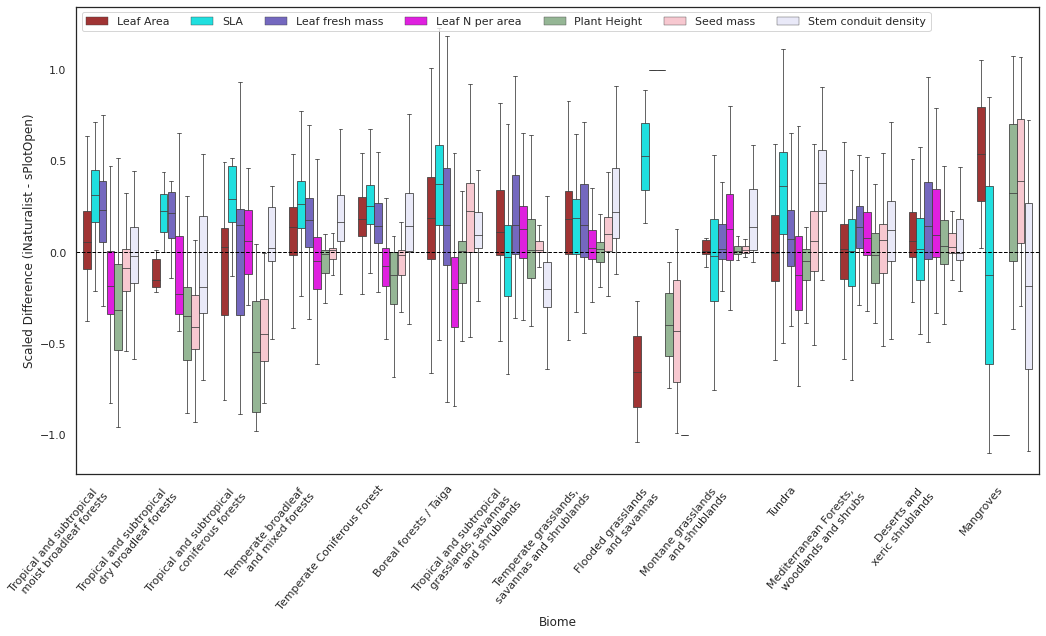

In [42]:
value_list = ['Leaf Area', 'SLA', 
       'Leaf fresh mass', 'Leaf N per area', 'Plant Height',
       'Seed mass', 
       'Stem conduit density']

xticklabels =["Tropical and subtropical \n moist broadleaf forests",
              "Tropical and subtropical \n dry broadleaf forests",
              "Tropical and subtropical \n coniferous forests",
              "Temperate broadleaf \n and mixed forests",
              "Temperate Coniferous Forest", 
              "Boreal forests / Taiga",
              "Tropical and subtropical \n grasslands, savannas \n and shrublands",
              "Temperate grasslands, \n savannas and shrublands",
              "Flooded grasslands \n and savannas",
              "Montane grasslands \n and shrublands",
              "Tundra",
              "Mediterranean Forests, \n woodlands and shrubs",
              "Deserts and \n xeric shrublands","Mangroves"]


boolean_series = raster_means_all.Trait.isin(value_list)
filtered_raster_means_all = raster_means_all[boolean_series]

# set figure size
sns.set(rc={'figure.figsize':(15,9)})

# plot
plot_boxplot(x="BIOME",y="Difference", hue="Trait", data=filtered_raster_means_all, xticklabels=xticklabels,
             ylabel= "Scaled Difference (iNaturalist - sPlotOpen)", xlabel="Biome")

plt.savefig('../Figures/wwf_difference_all_7.pdf', bbox_inches='tight')

Aggregate the forests in to the 3 main categories: 

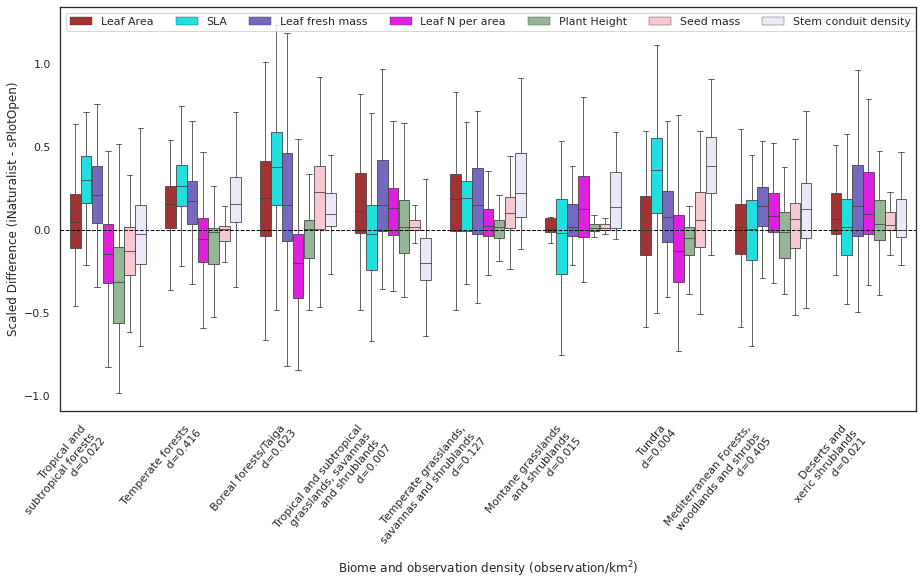

In [43]:
# Difference
value_list = ['Leaf Area', 'SLA', 
       'Leaf fresh mass', 'Leaf N per area', 'Plant Height',
       'Seed mass', 
       'Stem conduit density']

xticklabels =["Tropical and \n subtropical forests \n d=" + 
              str(round(agg_biomes['Obs_Density'].loc[['Tropical and subtropical forests']][0], 3)),
              "Temperate forests \n d=" + 
              str(round(agg_biomes['Obs_Density'].loc[['Temperate forests']][0], 3)), 
              "Boreal forests/Taiga \n d=" + 
              str(round(agg_biomes['Obs_Density'].loc[['Boreal forests/Taiga']][0], 3)),
              "Tropical and subtropical \n grasslands, savannas \n and shrublands \n d=" + 
              str(round(agg_biomes['Obs_Density'].loc[['Tropical and subtropical grasslands, savannas and shrublands']][0], 3)),
              "Temperate grasslands, \n savannas and shrublands \n d=" + 
              str(round(agg_biomes['Obs_Density'].loc[['Temperate grasslands, savannas and shrublands']][0], 3)),
              "Montane grasslands \n and shrublands \n d=" + 
              str(round(agg_biomes['Obs_Density'].loc[['Montane grasslands and shrublands']][0], 3)),
              "Tundra \n d=" + 
              str(round(agg_biomes['Obs_Density'].loc[['Tundra']][0], 3)),
              "Mediterranean Forests, \n woodlands and shrubs \n d=" + 
              str(round(agg_biomes['Obs_Density'].loc[['Mediterranean Forests, woodlands and shrubs']][0], 3)),
              "Deserts and \n xeric shrublands\n d=" + 
              str(round(agg_biomes['Obs_Density'].loc[['Deserts and xeric shrublands']][0], 3))]

order = ["Tropical and subtropical forests",
        "Tropical and subtropical grasslands, savannas and shrublands",
        "Deserts and xeric shrublands",
        "Montane grasslands and shrublands",
        "Mediterranean Forests, woodlands and shrubs",
        "Temperate forests",
        "Temperate grasslands, savannas and shrublands",
        "Boreal forests/Taiga",
        "Tundra"]

boolean_series = raster_means_all.Trait.isin(value_list)
filtered_raster_means_all = raster_means_all[boolean_series]

boolean_series = filtered_raster_means_all.AggBiome.isin(order)
filtered_raster_means_all = filtered_raster_means_all[boolean_series]



# set figure size
sns.set(rc={'figure.figsize':(14,8.3)})

# plot
plot_boxplot(x="AggBiome",y="Difference", hue="Trait", data=filtered_raster_means_all, xticklabels=xticklabels, 
             xlabel = "Biome and observation density (observation/km$^2$)",
             ylabel = "Scaled Difference (iNaturalist - sPlotOpen)")


plt.savefig('../Figures/wwf_biomes_aggr_7.pdf', bbox_inches='tight', transparent=True)  


## Quantify average difference

In [44]:
raster_means_all = pd.read_csv("raster_means_biomes_all_traits.csv")

In [45]:
trait = ['Leaf Area', 'SLA', 
       'Leaf fresh mass', 'Leaf N per area', 'Plant Height',
       'Seed mass', 
       'Stem conduit density']

boolean_series = raster_means_all.Trait.isin(value_list)
filtered_raster_means_all = raster_means_all[boolean_series]

In [46]:
pd.set_option('display.max_rows', None)
medians= pd.DataFrame(filtered_raster_means_all.groupby(['AggBiome', 'Trait']).median()['Difference'])
medians.head()


Difference
AggBiome             Trait                      
Boreal forests/Taiga Leaf Area          0.189220
                     Leaf N per area   -0.198705
                     Leaf fresh mass    0.148177
                     Plant Height       0.006025
                     SLA                0.375851

In [47]:
medians = medians.reset_index(level=['AggBiome', 'Trait'])

Medians per trop trait in each biome:

In [48]:
medians = medians.pivot_table(index ='AggBiome', columns = 'Trait',
               values = 'Difference')

medians.loc["All Biomes"] = list(filtered_raster_means_all.groupby(['Trait']).median()['Difference'])
medians

Trait,Leaf Area,Leaf N per area,Leaf fresh mass,Plant Height,SLA,Seed mass,Stem conduit density
AggBiome,,,,,,,
Boreal forests/Taiga,0.189220,-0.198705,0.148177,0.006025,0.375851,0.224411,0.093886
Deserts and xeric shrublands,0.061735,0.093049,0.141257,0.035254,0.016465,0.028652,-0.001412
Flooded grasslands and savannas,-0.653303,1.000000,1.000000,-0.397079,0.525346,-0.431093,-1.000000
Mangroves,0.537941,-1.000000,-1.000000,0.326003,-0.123916,0.388160,-0.182905
"Mediterranean Forests, woodlands and shrubs",0.015451,0.080470,0.139528,-0.013588,0.006157,0.064718,0.122965
Montane grasslands and shrublands,0.006176,0.125810,0.017283,0.007673,-0.018235,0.010105,0.137477
Temperate forests,0.151391,-0.058464,0.175030,-0.015376,0.263396,0.003792,0.152510
"Temperate grasslands, savannas and shrublands",0.183634,0.024759,0.147126,0.018820,0.187566,0.099922,0.220428
Tropical and subtropical forests,0.047930,-0.147661,0.206381,-0.317911,0.298611,-0.129097,-0.025443


In [49]:
medians = medians.round(2)

In [50]:
print(medians.to_latex(index=True))

\begin{tabular}{lrrrrrrr}
\toprule
Trait &  Leaf Area &  Leaf N per area &  Leaf fresh mass &  Plant Height &   SLA &  Seed mass &  Stem conduit density \\
AggBiome                                           &            &                  &                  &               &       &            &                       \\
\midrule
Boreal forests/Taiga                               &       0.19 &            -0.20 &             0.15 &          0.01 &  0.38 &       0.22 &                  0.09 \\
Deserts and xeric shrublands                       &       0.06 &             0.09 &             0.14 &          0.04 &  0.02 &       0.03 &                 -0.00 \\
Flooded grasslands and savannas                    &      -0.65 &             1.00 &             1.00 &         -0.40 &  0.53 &      -0.43 &                 -1.00 \\
Mangroves                                          &       0.54 &            -1.00 &            -1.00 &          0.33 & -0.12 &       0.39 &                 -0.18 \\
Medit